In [1]:
data_choice = 5

In [2]:
import time
start = time.time()

In [3]:
import sys
transformer_path = 'D:\FAST\FYP\FYP23-Deep-Document-Clustering\Transformer' # ==== Path for transformer folder
sys.path.insert(0, transformer_path)

In [4]:
data_path = "D:/FAST/FYP/FYP23-Deep-Document-Clustering/data/" # ===== Path for data

In [5]:
import numpy as np
import pandas as pd
import nltk
import os
import warnings
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import f1_score 
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import torch
import random

from utils.Encoder import Encoder
from utils.PositionalEncoding import PositionalEncoding

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.feature_extraction.text")


c:\Users\Ali Ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
if torch.cuda.is_available():
    print(f"Available GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Available GPU: NVIDIA GeForce RTX 4090


In [7]:
options = []
choice = None

In [8]:
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   torch.manual_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

def Purity_Score(label_seq, pred_labels):
    # Calculate the confusion matrix to compare true labels and cluster assignments
    confusion = confusion_matrix(label_seq, pred_labels)
    # Calculate the purity
    purity = np.sum(np.max(confusion, axis=0)) / np.sum(confusion)
    return purity


def Evaluate(X, true_labels, predicted_labels):
    purity = Purity_Score(true_labels, predicted_labels)
    silhouette = silhouette_score(X, predicted_labels, metric='euclidean')
    ari = ari_score(true_labels, predicted_labels)
    nmi = nmi_score(true_labels, predicted_labels)
    
    with open("D:\FAST\FYP\FYP23-Deep-Document-Clustering\Results.txt", "a") as f:
        f.write(f"\t Purity: {purity:.2f}\n"
                f"\t Silhouette Score: {silhouette:.2f}\n"
                f"\t NMI: {nmi:.2f}\n"
                f"\t ARI: {ari:.2f}\n")
    
    print(f"Purity: {purity}")
    print(f"Silhouette Score: {silhouette}")
    print(f"ARI Score: {ari}")
    print(f"NMI Score: {nmi}")

def SaveFeatures(X, file_name):
    pickle_path = open(file_name, 'wb')
    pickle.dump(X, pickle_path)
    pickle_path.close()

def ReadFeatures(file_name):
    pickle_read = open(file_name, 'rb')
    x = pickle.load(pickle_read)
    pickle_read.close()
    return x

In [9]:
def display_options(options):
    print("Select one of the following options:")
    for i, option in enumerate(options):
        print(f"{i + 1}. {option}")

def get_user_choice(options):
    while True:
        try:
            choice = int(input("Enter the number corresponding to your choice: "))
            if 1 <= choice <= len(options):
                return choice
            else:
                print("Invalid choice. Please enter a number within the range.")
        except ValueError:
            print("Invalid input. Please enter a number.")

options = ["ACM", "BBC","Reuters","Cite", "Doc50"]  # Sample options
display_options(options)
# choice = get_user_choice(options)
choice = data_choice
print(f"You chose: {options[choice - 1]}")


Select one of the following options:
1. ACM
2. BBC
3. Reuters
4. Cite
5. Doc50
You chose: Doc50


In [10]:
with open("D:\FAST\FYP\FYP23-Deep-Document-Clustering\Results.txt", "w") as f:
    f.write(f"{options[choice - 1]}\n\n")

In [11]:
os.chdir(data_path)

In [12]:
x = np.loadtxt(f"{options[choice - 1]}.txt", dtype=float)
y = np.loadtxt(f"{options[choice - 1]}_label.txt", dtype=int)

In [13]:
x = torch.tensor(x, dtype=torch.float32)

In [14]:
x.device

device(type='cpu')

In [15]:
x.size()

torch.Size([50, 3885])

In [16]:
# configurations for ACM
if(choice == 1):
   
    d_model = 1870
    num_heads = 1
    drop_prob = 0.1
    batch_size = 25
    max_sequence_length = 3025
    ffn_hidden = 2048
    num_layers = 5
    n_clusters = 3
    random_states = 500
    gpu = True

# configurations for BBC
elif(choice == 2):
    
    d_model = 9635
    num_heads = 1
    drop_prob = 0.1
    num_batches = 25
    max_sequence_length = 2225
    ffn_hidden = 2048
    num_layers = 5
    n_clusters = 5
    random_states = 500
    gpu = True

# configurations for Reuters
elif(choice == 3):
    
    d_model = 2000
    num_heads = 1
    drop_prob = 0.1
    num_batches = 25
    max_sequence_length = 10000
    ffn_hidden = 2048
    num_layers = 5
    n_clusters = 4
    random_states = 8
    gpu = True

# configurations for Citeseer
elif(choice == 4):
    
    d_model = 3703
    num_heads = 1
    drop_prob = 0.1
    num_batches = 3
    max_sequence_length = 3327
    ffn_hidden = 2048
    num_layers = 3
    n_clusters = 6
    random_states = 16
    gpu = True

# configurations for Doc50
elif(choice == 5):
    
    d_model = 3885
    num_heads = 1
    drop_prob = 0.1
    num_batches = 50
    max_sequence_length = 50
    ffn_hidden = 2048
    num_layers = 5
    n_clusters = 5
    random_states = 500
    gpu = False


In [17]:
if gpu and not torch.cuda.is_available():
    raise Exception("GPU is not available in this device")

In [18]:
pe = PositionalEncoding(d_model=d_model, max_sequence_length=max_sequence_length)
positional_encoding = pe.forward()

In [19]:
dim_diff = d_model - positional_encoding.shape[1]  

if dim_diff != 0:
    positional_encoding = positional_encoding[:,0:dim_diff]

positional_encoding.size()

torch.Size([50, 3885])

In [20]:
x = x + positional_encoding

In [21]:
try:
    x = x.reshape(shape=(num_batches, x.size()[0] // num_batches, x.size()[1]))
    print(x.size())
except Exception as e:
    raise Exception(e)

torch.Size([50, 1, 3885])


In [22]:
if gpu:
    print("Moving feature tensor to GPU memory")
    x = x.cuda()
    print(x.device)
else:
    print("Feature tensor stored in CPU memory")
    print(x.device)

Feature tensor stored in CPU memory
cpu


In [23]:
%%time
reset_random_seeds(42)
if gpu:
    print("Developing encoder for GPU")
    encoder = Encoder(d_model=d_model, ffn_hidden=ffn_hidden, num_heads=num_heads, drop_prob=drop_prob, num_layers=num_layers).cuda()
    torch.cuda.memory_allocated()
else:
    print("Developing encoder for CPU")
    encoder = Encoder(d_model=d_model, ffn_hidden=ffn_hidden, num_heads=num_heads, drop_prob=drop_prob, num_layers=num_layers)

Developing encoder for CPU


CPU times: total: 188 ms
Wall time: 892 ms


In [24]:
if gpu:
    for i in encoder.parameters():
        print(i.is_cuda)
else:
    print("Encoder in CPU")

Encoder in CPU


In [25]:
%%time
out = encoder(x)

x.size(): torch.Size([50, 1, 3885])
tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.0000e+00,  0.0000e+00]],

        [[ 8.4147e-01,  5.4030e-01,  8.3891e-01,  ...,  1.0071e-04,
           1.0000e+00,  1.0024e-04]],

        [[ 9.0930e-01, -4.1615e-01,  9.1319e-01,  ...,  2.0143e-04,
           1.0000e+00,  2.0047e-04]],

        ...,

        [[ 1.2357e-01, -9.9234e-01,  3.3934e-01,  ...,  4.7335e-03,
           9.9999e-01,  4.7111e-03]],

        [[-7.6825e-01, -6.4014e-01, -6.0443e-01,  ...,  4.8342e-03,
           9.9999e-01,  4.8114e-03]],

        [[-9.5375e-01,  3.0059e-01, -9.9730e-01,  ...,  4.9350e-03,
           9.9999e-01,  4.9116e-03]]])
qkv.size(): torch.Size([50, 1, 11655])
50, 1, 1, 3885
qkv.size(): torch.Size([50, 1, 1, 11655])
q.size(): torch.Size([50, 1, 1, 3885]), k.size(): torch.Size([50, 1, 1, 3885]), v.size(): torch.Size([50, 1, 1, 3885])
values.size(): torch.Size([50, 1, 1, 3885]), attention.size(): torch.Size([50, 1, 1, 1])
x.si

In [26]:
def KMeans_Labels(X, n, rstate_limit, true_labels):
    # Specify the number of clusters (you can choose an appropriate value)
    num_clusters = n
    
    # find centoids which give maximum purity
    purity_collection = {}
    for i in range(rstate_limit):
        clusters = KMeans(n_init='auto', n_clusters=num_clusters, random_state=i, init='k-means++').fit(X).labels_
        purity_collection[i] = Purity_Score(true_labels, clusters)
    
    max_rand_state = max(purity_collection, key=purity_collection.get)
    print(f"Maximum purity of {purity_collection[max_rand_state]} found on random state {max_rand_state}")

    plot_graph(purity_collection.keys(), purity_collection.values())
    
    # Create a KMeans model
    kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=max_rand_state, init='k-means++')
    # Fit the KMeans model to the TF-IDF data
    kmeans.fit(X)
    # Get the cluster assignments for each document
    cluster_assignments = kmeans.labels_
    
    return cluster_assignments

def plot_graph(x, y):
    plt.scatter(x, y, marker = "o")
    plt.title("Purity x Random State")
    plt.ylabel("Purity")
    plt.xlabel("Random State")
    purity_save_path = "D:\FAST\FYP\FYP23-Deep-Document-Clustering\Purity_Image.png"
    with open(purity_save_path, "w") as f:
        plt.savefig(purity_save_path)
    plt.show()

def calculate_purity(random_state, X, true_labels):
    clusters = KMeans(n_init='auto', n_clusters=num_clusters, random_state=random_state, init='k-means++').fit(X).labels_
    purity = Purity_Score(true_labels, clusters)
    return random_state, purity

def KMeans_Labels_Parallel(X, n, rstate_limit, true_labels):
    # Specify the number of clusters (you can choose an appropriate value)
    global num_clusters
    num_clusters = n
    purity_collection = {}

    for i in range(0, rstate_limit, 100):
        # Use ThreadPoolExecutor to parallelize purity calculations
        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(calculate_purity, i, X, true_labels): i for i in range(i, i+16)}
        temp_purity_collection = {future.result()[0]: future.result()[1] for future in futures}
        purity_collection.update(temp_purity_collection)

    max_rand_state = max(purity_collection, key=purity_collection.get)
    print(f"Maximum purity of {purity_collection[max_rand_state]} found on random state {max_rand_state}")

    plot_graph(purity_collection.keys(), purity_collection.values())
    
    # Create a KMeans model
    kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=max_rand_state, init='k-means++')
    # Fit the KMeans model to the data
    kmeans.fit(X)
    # Get the cluster assignments for each data point
    cluster_assignments = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    
    return cluster_assignments, cluster_centers


In [27]:
reshaped_out = out.reshape(out.size()[0] * out.size()[1], out.size()[2])
print(reshaped_out.size())
enhanced_x = reshaped_out.cpu().detach().numpy()

torch.Size([50, 3885])


In [28]:
del reshaped_out
del out
del encoder
del x

Find best clusters for 500 random states
Maximum purity of 0.96 found on random state 3


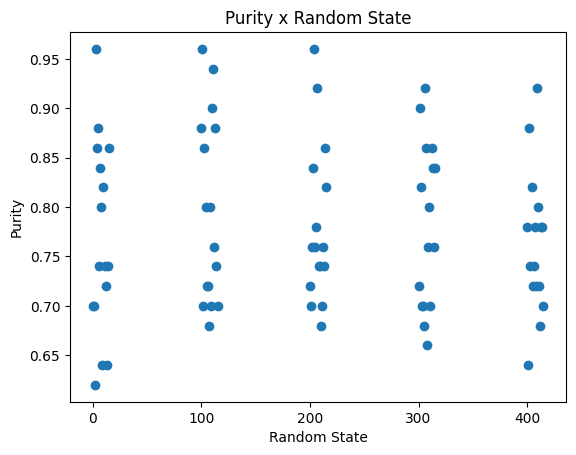

CPU times: total: 15.5 s
Wall time: 1.3 s


In [29]:
%%time
true_labels = y
print(f"Find best clusters for {random_states} random states")
pred_lables, centoids = KMeans_Labels_Parallel(enhanced_x, n_clusters, random_states, true_labels)

In [30]:
Evaluate(enhanced_x, true_labels, pred_lables)

Purity: 0.96
Silhouette Score: 0.16761328279972076
ARI Score: 0.8969106411250138
NMI Score: 0.9178588423361494


In [31]:
def visualize_clusters(X, cluster_assignments, cluster_centers, num_dimensions=2):
    # Apply PCA to reduce the dimensions for visualization
    pca = PCA(n_components=num_dimensions)
    X_pca = pca.fit_transform(X)

    # Combine data and cluster assignments into a DataFrame
    data_with_clusters = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, num_dimensions+1)])
    data_with_clusters['Cluster'] = cluster_assignments

    # Scatter plot with different colors for each cluster
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=data_with_clusters, palette='viridis', s=80, alpha=0.8)
    
    # Plot cluster centers if available
    centers = pca.transform(cluster_centers)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
    
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    cluster_save_path = "D:\FAST\FYP\FYP23-Deep-Document-Clustering\Cluster_Image.png"
    with open(cluster_save_path, "w") as f:
        plt.savefig(cluster_save_path)
    plt.show()
    


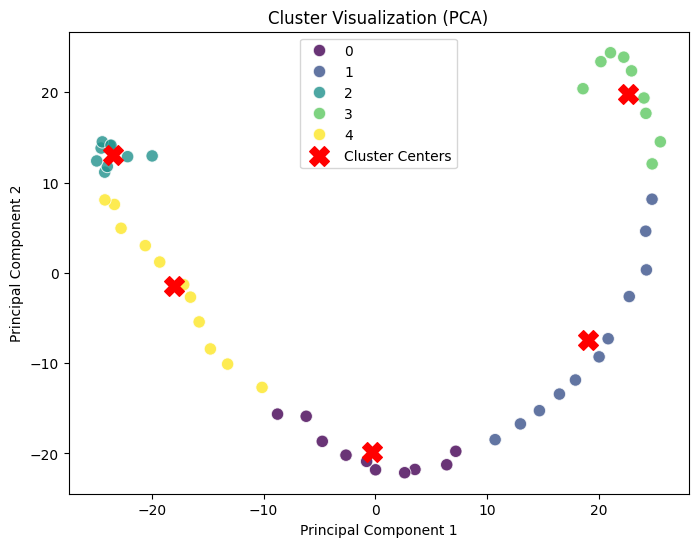

In [32]:
visualize_clusters(enhanced_x, pred_lables, cluster_centers=centoids, num_dimensions=2)

In [33]:
i=0
while i<len(true_labels):
    print(f"From {i} - {i+300}")
    print(true_labels[i:i+300])
    print(pred_lables[i:i+300])
    i+=300

From 0 - 300
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4]
[3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4
 4 4 4 4 2 2 2 2 2 2 2 2 2]


In [34]:
end = time.time()
time_taken = end - start

In [35]:
print(f"Time taken: {time_taken:.2f}s")

Time taken: 3.91s
